In [1]:
!nvidia-smi

Fri Oct  2 03:23:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download dataset from Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
if not os.path.exists('carvana'):
    os.mkdir('carvana')
!unzip '/content/drive/My Drive/datasets/Carvana Car Masking/carvana-car-masking.zip' -d '/content/carvana'

Streaming output truncated to the last 5000 lines.
  inflating: /content/carvana/images/train/0789bed99cb8_10.jpg  
  inflating: /content/carvana/images/train/0789bed99cb8_11.jpg  
  inflating: /content/carvana/images/train/0789bed99cb8_12.jpg  
  inflating: /content/carvana/images/train/0789bed99cb8_13.jpg  
  inflating: /content/carvana/images/train/0789bed99cb8_14.jpg  
  inflating: /content/carvana/images/train/0789bed99cb8_15.jpg  
  inflating: /content/carvana/images/train/0789bed99cb8_16.jpg  
  inflating: /content/carvana/images/train/0795e132d090_01.jpg  
  inflating: /content/carvana/images/train/0795e132d090_02.jpg  
  inflating: /content/carvana/images/train/0795e132d090_03.jpg  
  inflating: /content/carvana/images/train/0795e132d090_04.jpg  
  inflating: /content/carvana/images/train/0795e132d090_05.jpg  
  inflating: /content/carvana/images/train/0795e132d090_06.jpg  
  inflating: /content/carvana/images/train/0795e132d090_07.jpg  
  inflating: /content/carvana/images/tr

## Import Pytorch

In [4]:
import os
import cv2
import time
import json
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import models

torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Read and process data

In [5]:
df = pd.read_csv('/content/carvana/annotations/train_masks.csv')
print(len(df))
train_df, val_df = train_test_split(df, train_size=0.8, random_state=2020)
df.head()

5088


,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
def denormalize(img, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]): 
    mean = np.array(mean)
    std = np.array(std)
    img_show = img.clone()
    if img_show.shape[0] == 1:
        img_show = img_show.squeeze(0)
    img_show = img_show.numpy().transpose((1,2,0))
    img_show = (img_show * std+mean)
    img_show = np.clip(img_show,0,1)
    return img_show

In [7]:
class CarvanaMask(data.Dataset):
    def __init__(self, img_path, mask_path, dataframe = None, transforms = None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.df = dataframe
        self.transforms = transforms
        self.load_data()

    def load_data(self):
        self.fns = []
        for idx, row in self.df.iterrows():
            img_name = row[0]
            mask_name = img_name[:-4] + '_mask.gif'
            img_path = os.path.join(self.img_path,img_name)
            mask_path = os.path.join(self.mask_path,mask_name)
            self.fns.append([img_path, mask_path])
    
    def visualize_some(self, num_samples = 5):
        a = [np.random.randint(0,len(self.fns)) for i in range(num_samples)]
        for i in a:
            self.visualize_item(i)

    def visualize_item(self, idx, figsize = (10,10)):
        item = self.__getitem__(idx)
        img, mask = item['img'], item['mask']
        img = denormalize(img)
        mask = mask.squeeze(0)
        plt.figure(figsize=figsize)
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.subplot(1,2,2)
        plt.imshow(mask)

        plt.show()
    
    def __getitem__(self, idx):
        img_path, label_path = self.fns[idx]
        img = Image.open(img_path)
        mask = Image.open(label_path)
        img = np.array(img)
        mask = np.array(mask)
        if self.transforms is not None:
            item = self.transforms(image = img, mask = mask)
            img, mask = item['image'], item['mask']

            img = ToTensor()(img)
            mask = torch.FloatTensor(mask)
            

        return {'img': img, 'mask': mask}
    
    
    def collate_fn(self, batch):
        imgs = torch.stack([i['img'] for i in batch])
        masks = torch.stack([i['mask'] for i in batch]).unsqueeze(1)
        return {
            'imgs': imgs,
            'masks': masks
        }
    
    def __len__(self):
        return len(self.fns)

## Data augmentations and Dataloader

In [8]:
!pip install albumentations
import albumentations as A
from torchvision.transforms import ToTensor

train_transforms = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.Rotate(20, p=0.5),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

     |████████████████████████████████| 634kB 7.4MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=6fd97cf6a6f9228e9af25d425bb8a530e70475cda544e610187d4887176350c4
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [9]:
trainset = CarvanaMask(img_path = '/content/carvana/images/train', mask_path='/content/carvana/annotations/train_masks', dataframe= train_df, transforms = train_transforms)
valset = CarvanaMask(img_path = '/content/carvana/images/train', mask_path='/content/carvana/annotations/train_masks', dataframe= val_df, transforms = val_transforms)
trainloader = data.DataLoader(trainset, batch_size=4, collate_fn=trainset.collate_fn, num_workers = 4, pin_memory=True)
valloader = data.DataLoader(valset, batch_size=4, collate_fn=valset.collate_fn, num_workers = 4, pin_memory=True)
print(f"Number of training samples: {len(trainset)}")
print(f"Number of validating samples: {len(valset)}")

Number of training samples: 4070
Number of validating samples: 1018


## Visualize training set

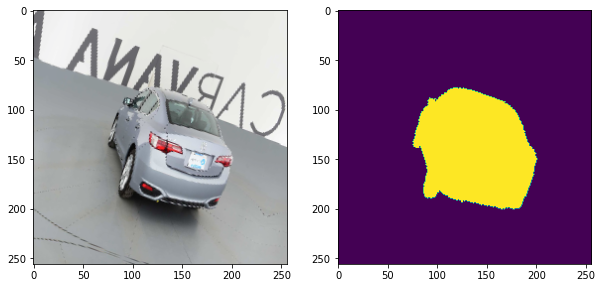

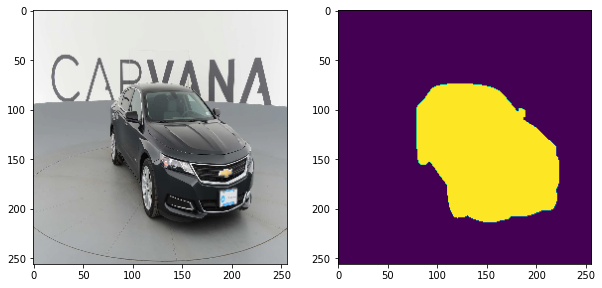

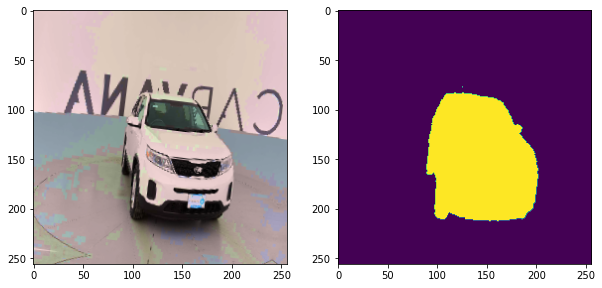

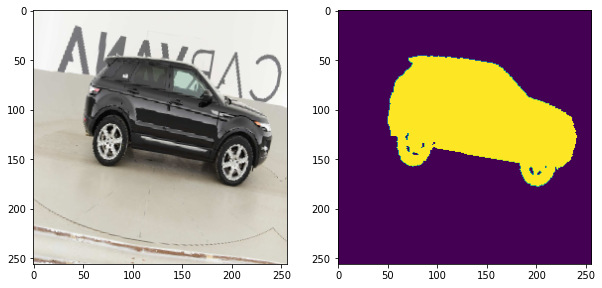

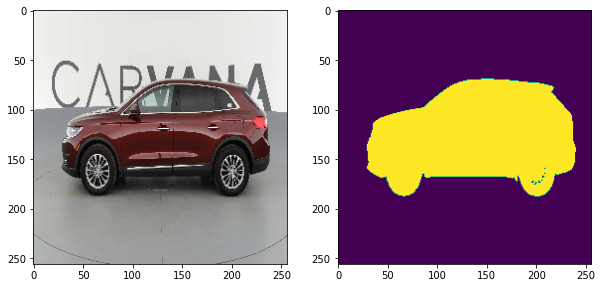

In [10]:
trainset.visualize_some()

In [11]:
for batch in trainloader:
    imgs = batch['imgs']
    masks = batch['masks']
    print(imgs.shape)
    print(masks.shape)
    break

torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])


## UNet Plus model

In [12]:
class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output
    
#Nested Unet

class NestedUNet(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(NestedUNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output


In [13]:
class UNetPlus(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.name = 'nested_unet'
        self.net = NestedUNet(in_ch=3, out_ch=num_classes)
        
    def zero_grad(self):
        for params in self.parameters():
            params.grad = None
                
    def forward(self, inputs):
        # Bx3x512x512
        x = self.net(inputs)
        x = torch.sigmoid(x)
        return x
        

## Dice Loss

In [17]:
class DiceLoss(nn.Module):
    """
    Source: https://github.com/hubutui/DiceLoss-PyTorch/blob/master/loss.py
    Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

In [18]:
class TotalLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss()
        self.bce = nn.BCELoss()
    def forward(self, outputs, targets):
        return self.dice(outputs, targets) + self.bce(outputs, targets)

## Metrics: Dice Coefficient and Pixel Accuracy


In [112]:
class DiceScore():
    def __init__(self, num_classes, ignore_index = None, eps=1e-6, thresh = 0.5):
        self.thresh = thresh
        self.num_classes = num_classes
        self.pred_type = "multi" if num_classes > 1 else "binary"

        if num_classes == 1:
            self.num_classes+=1
        
        self.ignore_index = ignore_index
        self.eps = eps

        self.scores_list = np.zeros(self.num_classes)
        self.reset()

    def compute(self, outputs, targets): 
        # outputs: (batch, num_classes, W, H)
        # targets: (batch, num_classes, W, H)
      
        batch_size, _ , w, h = outputs.shape
        if len(targets.shape) == 3:
            targets = targets.unsqueeze(1)
      
        one_hot_targets = torch.zeros(batch_size, self.num_classes, h, w)
        one_hot_predicts = torch.zeros(batch_size, self.num_classes, h, w)
        
        if self.pred_type == 'binary':
            predicts = (outputs > self.thresh).float()
        elif self.pred_type =='multi':
            predicts = torch.argmax(outputs, dim=1).unsqueeze(1)

        one_hot_targets.scatter_(1, targets.long(), 1)
        one_hot_predicts.scatter_(1, predicts.long(), 1)
        
        for cl in range(self.num_classes):
            cl_pred = one_hot_predicts[:,cl,:,:]
            cl_target = one_hot_targets[:,cl,:,:]
            score = self.binary_compute(cl_pred, cl_target)
            self.scores_list[cl] += sum(score)
        

    def binary_compute(self, predict, target):
        # outputs: (batch, 1, W, H)
        # targets: (batch, 1, W, H)

        intersect = (predict * target).sum((-2,-1))
        union = (predict + target).sum((-2,-1))
        return (2. * intersect + self.eps) / (union +self.eps)
        
    def reset(self):
        self.scores_list = np.zeros(self.num_classes)
        self.sample_size = 0

    def update(self, outputs, targets):
        self.sample_size += outputs.shape[0]
        self.compute(outputs, targets)

    def value(self):
        scores_each_class = self.scores_list / self.sample_size #mean over number of samples
        if self.pred_type == 'binary':
            scores = scores_each_class[1] # ignore background which is label 0
        else:
            scores = sum(scores_each_class) / self.num_classes
        return {"dice_score" : np.round(scores, decimals=4)}

    def summary(self):
        class_iou = self.scores_list / self.sample_size #mean
        
        print(f'{self.value()}')
        for i, x in enumerate(class_iou):
            print(f'\tClass {i}: {x:.4f}')

    def __str__(self):
        return f'Dice Score: {self.value()}'

    def __len__(self):
        return len(self.sample_size)

    

In [113]:
class PixelAccuracy():
    def __init__(self, num_classes, ignore_index=None, eps=1e-6, thresh = 0.5):
        self.thresh = thresh
        self.num_classes = num_classes
        self.pred_type = "multi" if num_classes > 1 else "binary"

        if num_classes == 1:
            self.num_classes+=1
        
        self.ignore_index = ignore_index
        self.eps = eps

        self.scores_list = np.zeros(self.num_classes)
        self.reset()

    def compute(self, outputs, targets): 
        # outputs: (batch, num_classes, W, H)
        # targets: (batch, num_classes, W, H)
      
        batch_size, _ , w, h = outputs.shape
        if len(targets.shape) == 3:
            targets = targets.unsqueeze(1)
      
        one_hot_targets = torch.zeros(batch_size, self.num_classes, h, w)
        one_hot_predicts = torch.zeros(batch_size, self.num_classes, h, w)
        
        if self.pred_type == 'binary':
            predicts = (outputs > self.thresh).float()
        elif self.pred_type =='multi':
            predicts = torch.argmax(outputs, dim=1).unsqueeze(1)

        one_hot_targets.scatter_(1, targets.long(), 1)
        one_hot_predicts.scatter_(1, predicts.long(), 1)
        
        for cl in range(self.num_classes):
            cl_pred = one_hot_predicts[:,cl,:,:]
            cl_target = one_hot_targets[:,cl,:,:]
            score = self.binary_compute(cl_pred, cl_target)
            self.scores_list[cl] += sum(score)

    def binary_compute(self, predict, target):
        # predict: (batch, 1, W, H)
        # targets: (batch, 1, W, H)

        correct = (predict == target).sum((-2,-1))
        total = target.shape[-1] * target.shape[-2]
        return (correct + self.eps) *1.0 / (total +self.eps)
        
    def reset(self):
        self.scores_list = np.zeros(self.num_classes)
        self.sample_size = 0

    def update(self, outputs, targets):
        self.sample_size += outputs.shape[0]
        self.compute(outputs, targets)

    def value(self):
        scores_each_class = self.scores_list / self.sample_size #mean over number of samples
        if self.pred_type == 'binary':
            scores = scores_each_class[1] # ignore background which is label 0
        else:
            scores = sum(scores_each_class) / self.num_classes
        return {"pixel_acc" : np.round(scores, decimals=4)}

    def summary(self):
        class_iou = self.scores_list / self.sample_size #mean
        
        print(f'{self.value()}')
        for i, x in enumerate(class_iou):
            print(f'\tClass {i}: {x:.4f}')

    def __str__(self):
        return f'Pixel Accuracy: {self.value()}'

    def __len__(self):
        return len(self.sample_size)

## Train model


In [16]:
def train(model, trainloader, valloader, optimizer, criterion, scheduler):
    global min_val_loss
    NUM_EPOCHS = 50
    
    print('===========================START TRAINING=================================') 
    for epoch in range(NUM_EPOCHS):
        train_epoch(epoch, NUM_EPOCHS,model, trainloader, optimizer, criterion)
        val_loss = validate_epoch(epoch, NUM_EPOCHS, model, valloader, criterion)
        scheduler.step() 
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), '/content/drive/My Drive/{}_{}_{:10.4f}.pth'.format(model.name, epoch, min_val_loss))   

In [111]:
def validate_epoch(epoch, NUM_EPOCHS, model, valloader, criterion):
      #Validate
      
      model.eval()
      metrics = [DiceScore(1), PixelAccuracy(1)]
      running_loss = {
          'T': 0
      }
      running_time = 0
      print('=============================EVALUATION===================================')
      with torch.no_grad():
          start_time = time.time()
          for idx, batch in enumerate(valloader):
              
              inputs = batch['imgs'].to(device)
              targets = batch['masks'].to(device)
              outputs = model(inputs)
              loss = criterion(outputs, targets)
              running_loss['T'] += (loss.item())
              for metric in metrics:
                  metric.update(outputs.cpu(), targets.cpu())

          end_time = time.time()
          running_time += (end_time - start_time)
          
          for key in running_loss.keys():
              running_loss[key] /= len(valloader)
          loss_string = '{}'.format(running_loss)[1:-1].replace("'",'').replace(",",' ||')
          
          print('[{}/{}] || Validation || {} || Time: {}s'.format(epoch+1, NUM_EPOCHS, loss_string, running_time))
          for metric in metrics:
              print(metric)
          print('==========================================================================')
      
      return running_loss['T']

In [14]:
def train_epoch(epoch, NUM_EPOCHS, model, trainloader, optimizerr, criterion):
      model.train()
      print_per_iter = 10
      running_loss = {
            'T': 0
        }
      running_time = 0
      for idx, batch in enumerate(trainloader):
          optimizer.zero_grad()
          inputs = batch['imgs'].to(device)
          targets = batch['masks'].to(device)
          
          start_time = time.time()
          
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          
          end_time = time.time()
          
          running_loss['T'] += loss.item()
          running_time += end_time-start_time
          
          if idx % print_per_iter == 0:
              for key in running_loss.keys():
                  running_loss[key] /= print_per_iter

              loss_string = '{}'.format(running_loss)[1:-1].replace("'",'').replace(",",' ||')
              
              print('[{}/{}][{}/{}] || {} || Time: {}s'.format(epoch+1, NUM_EPOCHS, idx+1, len(trainloader), loss_string,  running_time))
              running_time = 0
              running_loss = {
                  'T': 0
              }

In [20]:
model = UNetPlus(1).to(device)
criterion = TotalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, 0.1)

In [ ]:
min_val_loss = 2.0
train(model, trainloader, valloader, optimizer, criterion, scheduler)

===========================START TRAINING=================================
[1/50][1/1018] || T: 0.0006702926941215992 || Time: 0.7090685367584229s
[1/50][11/1018] || T: 0.006213220208883286 || Time: 6.264132022857666s
[1/50][21/1018] || T: 0.006824466027319431 || Time: 6.41972804069519s
[1/50][31/1018] || T: 0.006076094461604953 || Time: 6.4305267333984375s
[1/50][41/1018] || T: 0.006331246579065919 || Time: 6.528266668319702s
[1/50][51/1018] || T: 0.006067279633134604 || Time: 6.640759229660034s
[1/50][61/1018] || T: 0.0062933146953582765 || Time: 6.76436972618103s
[1/50][71/1018] || T: 0.006354205077514052 || Time: 6.831111669540405s
[1/50][81/1018] || T: 0.0061240847222507 || Time: 6.7826008796691895s
[1/50][91/1018] || T: 0.006368573196232319 || Time: 6.63225531578064s
[1/50][101/1018] || T: 0.005966695304960012 || Time: 6.579322814941406s
[1/50][111/1018] || T: 0.00579558308236301 || Time: 6.525088787078857s
[1/50][121/1018] || T: 0.005890166759490967 || Time: 6.507646560668945s
[


[1/50] || Validation || T: 0.005646270256051246 || Time: 63.136268615722656s
[2/50][1/1018] || T: 0.000605811458081007 || Time: 0.7126200199127197s
[2/50][11/1018] || T: 0.005512863863259554 || Time: 6.5936243534088135s
[2/50][21/1018] || T: 0.006185642536729574 || Time: 6.62247896194458s
[2/50][31/1018] || T: 0.005425408342853188 || Time: 6.634967565536499s
[2/50][41/1018] || T: 0.005683485325425864 || Time: 6.637501001358032s
[2/50][51/1018] || T: 0.005437146965414285 || Time: 6.63561487197876s
[2/50][61/1018] || T: 0.005683959973976016 || Time: 6.630125999450684s
[2/50][71/1018] || T: 0.005775244487449527 || Time: 6.628281831741333s
[2/50][81/1018] || T: 0.005547729320824146 || Time: 6.6292736530303955s
[2/50][91/1018] || T: 0.005825548386201263 || Time: 6.626317739486694s
[2/50][101/1018] || T: 0.005411041341722012 || Time: 6.6332573890686035s
[2/50][111/1018] || T: 0.005247960658743977 || Time: 6.6252405643463135s
[2/50][121/1018] || T: 0.005363357299938798 || Time: 6.62852835655


[2/50] || Validation || T: 0.0055503330211721215 || Time: 63.185596227645874s
[3/50][1/1018] || T: 0.0005940422881394625 || Time: 0.6492085456848145s
[3/50][11/1018] || T: 0.005391314253211021 || Time: 6.6411919593811035s
[3/50][21/1018] || T: 0.006062508141621947 || Time: 6.642876863479614s
[3/50][31/1018] || T: 0.005294657126069069 || Time: 6.6323583126068115s
[3/50][41/1018] || T: 0.005565446708351374 || Time: 6.629623174667358s
[3/50][51/1018] || T: 0.005314165866002441 || Time: 6.629520893096924s
[3/50][61/1018] || T: 0.005573938926681876 || Time: 6.634419918060303s
[3/50][71/1018] || T: 0.005677152099087835 || Time: 6.6324357986450195s
[3/50][81/1018] || T: 0.005423862719908357 || Time: 6.628113269805908s
[3/50][91/1018] || T: 0.005718363495543599 || Time: 6.647390604019165s
[3/50][101/1018] || T: 0.00530054927803576 || Time: 6.627270698547363s
[3/50][111/1018] || T: 0.005122376652434468 || Time: 6.634599447250366s
[3/50][121/1018] || T: 0.005229502962902188 || Time: 6.627031087


[3/50] || Validation || T: 0.005516901026096414 || Time: 63.08723759651184s
[4/50][1/1018] || T: 0.0005889645311981439 || Time: 0.6524815559387207s
[4/50][11/1018] || T: 0.005348870949819684 || Time: 6.654366731643677s
[4/50][21/1018] || T: 0.006022591004148125 || Time: 6.628458738327026s
[4/50][31/1018] || T: 0.0052519218996167185 || Time: 6.628659963607788s
[4/50][41/1018] || T: 0.005525463214144111 || Time: 6.6386637687683105s
[4/50][51/1018] || T: 0.005264708306640387 || Time: 6.642132997512817s
[4/50][61/1018] || T: 0.005522522376850247 || Time: 6.644111156463623s
[4/50][71/1018] || T: 0.005625507049262524 || Time: 6.619863510131836s
[4/50][81/1018] || T: 0.0053884505294263365 || Time: 6.625122308731079s
[4/50][91/1018] || T: 0.005672556115314364 || Time: 6.633454322814941s
[4/50][101/1018] || T: 0.00525337802246213 || Time: 6.62461256980896s
[4/50][111/1018] || T: 0.0050794417969882485 || Time: 6.633777856826782s
[4/50][121/1018] || T: 0.005196858895942569 || Time: 6.63476490974


[4/50] || Validation || T: 0.005493594723406668 || Time: 63.359721660614014s
[5/50][1/1018] || T: 0.000588089320808649 || Time: 0.6451530456542969s
[5/50][11/1018] || T: 0.005324897728860379 || Time: 6.654736757278442s
[5/50][21/1018] || T: 0.0060091974213719365 || Time: 6.6326072216033936s
[5/50][31/1018] || T: 0.0052243846002966166 || Time: 6.630848169326782s
[5/50][41/1018] || T: 0.005505446717143059 || Time: 6.625298976898193s
[5/50][51/1018] || T: 0.005241535324603319 || Time: 6.6374053955078125s
[5/50][61/1018] || T: 0.005501699727028608 || Time: 6.622058868408203s
[5/50][71/1018] || T: 0.005603493331000209 || Time: 6.621229410171509s
[5/50][81/1018] || T: 0.005370281683281064 || Time: 6.629934787750244s
[5/50][91/1018] || T: 0.005659708939492703 || Time: 6.635433673858643s
[5/50][101/1018] || T: 0.005236900458112359 || Time: 6.637572288513184s
[5/50][111/1018] || T: 0.005055713001638651 || Time: 6.629610300064087s
[5/50][121/1018] || T: 0.005174341378733516 || Time: 6.631087541


[5/50] || Validation || T: 0.0054860273850899114 || Time: 63.315253019332886s
[6/50][1/1018] || T: 0.0005867598112672568 || Time: 0.6472876071929932s
[6/50][11/1018] || T: 0.005310812359675765 || Time: 6.61635160446167s
[6/50][21/1018] || T: 0.005988920433446765 || Time: 6.64456582069397s
[6/50][31/1018] || T: 0.005208984250202775 || Time: 6.6355695724487305s
[6/50][41/1018] || T: 0.005489447433501482 || Time: 6.627417325973511s
[6/50][51/1018] || T: 0.005227901367470622 || Time: 6.6309239864349365s
[6/50][61/1018] || T: 0.005490741087123751 || Time: 6.631199598312378s
[6/50][71/1018] || T: 0.005583526846021414 || Time: 6.6316423416137695s
[6/50][81/1018] || T: 0.005349149368703366 || Time: 6.6506383419036865s
[6/50][91/1018] || T: 0.005638524983078241 || Time: 6.64046311378479s
[6/50][101/1018] || T: 0.005218338407576084 || Time: 6.632850885391235s
[6/50][111/1018] || T: 0.005041107628494501 || Time: 6.635128736495972s
[6/50][121/1018] || T: 0.005150100262835622 || Time: 6.6366491317


[6/50] || Validation || T: 0.005474894402512149 || Time: 63.636756896972656s
[7/50][1/1018] || T: 0.0005871776025742293 || Time: 0.6460840702056885s
[7/50][11/1018] || T: 0.005313617829233408 || Time: 6.649168014526367s
[7/50][21/1018] || T: 0.0059856563340872524 || Time: 6.627438306808472s
[7/50][31/1018] || T: 0.005203389143571257 || Time: 6.638536214828491s
[7/50][41/1018] || T: 0.005484221922233701 || Time: 6.611042737960815s
[7/50][51/1018] || T: 0.005218742019496858 || Time: 6.6358654499053955s
[7/50][61/1018] || T: 0.005499143386259675 || Time: 6.631872892379761s
[7/50][71/1018] || T: 0.005588685441762209 || Time: 6.631036281585693s
[7/50][81/1018] || T: 0.005349285574629903 || Time: 6.638659715652466s
[7/50][91/1018] || T: 0.005642067221924662 || Time: 6.627469539642334s
[7/50][101/1018] || T: 0.005219704983755946 || Time: 6.623504877090454s
[7/50][111/1018] || T: 0.005040352325886488 || Time: 6.62755560874939s
[7/50][121/1018] || T: 0.0051515405531972645 || Time: 6.6310212612


[7/50] || Validation || T: 0.005466378171581264 || Time: 63.314963817596436s
[8/50][1/1018] || T: 0.0005853145383298397 || Time: 0.6470260620117188s
[8/50][11/1018] || T: 0.005303501291200519 || Time: 6.630465269088745s
[8/50][21/1018] || T: 0.005970986187458038 || Time: 6.626504898071289s
[8/50][31/1018] || T: 0.005199204059317708 || Time: 6.632043123245239s
[8/50][41/1018] || T: 0.005478078825399279 || Time: 6.629884958267212s
[8/50][51/1018] || T: 0.005215608049184084 || Time: 6.638140439987183s
[8/50][61/1018] || T: 0.005472770798951388 || Time: 6.627753973007202s
[8/50][71/1018] || T: 0.005575180193409324 || Time: 6.6307971477508545s
[8/50][81/1018] || T: 0.005340091791003943 || Time: 6.627960443496704s
[8/50][91/1018] || T: 0.005629721889272332 || Time: 6.631509065628052s
[8/50][101/1018] || T: 0.005209083203226328 || Time: 6.625264644622803s
[8/50][111/1018] || T: 0.005030858749523759 || Time: 6.628722667694092s
[8/50][121/1018] || T: 0.005141916871070862 || Time: 6.64831447601


[8/50] || Validation || T: 0.005463253955046336 || Time: 63.575913429260254s
[9/50][1/1018] || T: 0.0005852495320141316 || Time: 0.6419332027435303s
[9/50][11/1018] || T: 0.005296727828681469 || Time: 6.638460159301758s
[9/50][21/1018] || T: 0.005972270714119076 || Time: 6.642874240875244s
[9/50][31/1018] || T: 0.005197863979265094 || Time: 6.633521795272827s
[9/50][41/1018] || T: 0.005478163715451956 || Time: 6.618862867355347s
[9/50][51/1018] || T: 0.005213496321812272 || Time: 6.625125885009766s
[9/50][61/1018] || T: 0.005473475204780698 || Time: 6.624172925949097s
[9/50][71/1018] || T: 0.005573084251955152 || Time: 6.625662565231323s
[9/50][81/1018] || T: 0.005340936314314604 || Time: 6.6304240226745605s
[9/50][91/1018] || T: 0.005625796085223555 || Time: 6.632137298583984s
[9/50][101/1018] || T: 0.005212409002706408 || Time: 6.636342287063599s
[9/50][111/1018] || T: 0.005030721845105291 || Time: 6.621953725814819s
[9/50][121/1018] || T: 0.0051465668249875305 || Time: 6.6324341297


[9/50] || Validation || T: 0.0054620061124510625 || Time: 63.34626245498657s
[10/50][1/1018] || T: 0.0005864166654646396 || Time: 0.6495797634124756s
[10/50][11/1018] || T: 0.005294714728370309 || Time: 6.639896869659424s
[10/50][21/1018] || T: 0.005972541216760874 || Time: 6.632370233535767s
[10/50][31/1018] || T: 0.005197875155135989 || Time: 6.624022006988525s
[10/50][41/1018] || T: 0.005475722206756473 || Time: 6.624010324478149s
[10/50][51/1018] || T: 0.005213826522231102 || Time: 6.633973836898804s
[10/50][61/1018] || T: 0.005474114790558815 || Time: 6.637081861495972s
[10/50][71/1018] || T: 0.005572688113898039 || Time: 6.644497394561768s
[10/50][81/1018] || T: 0.0053359678946435455 || Time: 6.64835000038147s
[10/50][91/1018] || T: 0.005623057018965483 || Time: 6.650268077850342s
[10/50][101/1018] || T: 0.005206422554329038 || Time: 6.64417576789856s
[10/50][111/1018] || T: 0.005028277216479182 || Time: 6.6155126094818115s
[10/50][121/1018] || T: 0.005139818135648966 || Time: 6


[10/50] || Validation || T: 0.005461520862345602 || Time: 63.344582080841064s
[11/50][1/1018] || T: 0.0005849968641996383 || Time: 0.704108476638794s
[11/50][11/1018] || T: 0.0052959959954023365 || Time: 6.6281702518463135s
[11/50][21/1018] || T: 0.005967268254607916 || Time: 6.626190662384033s
[11/50][31/1018] || T: 0.005192471761256456 || Time: 6.629510164260864s
[11/50][41/1018] || T: 0.005477585410699248 || Time: 6.625513553619385s
[11/50][51/1018] || T: 0.005212207231670618 || Time: 6.633902549743652s
[11/50][61/1018] || T: 0.005468479823321104 || Time: 6.628330707550049s
[11/50][71/1018] || T: 0.005571123445406556 || Time: 6.6247336864471436s
[11/50][81/1018] || T: 0.005330918496474624 || Time: 6.628223896026611s
[11/50][91/1018] || T: 0.005618507834151387 || Time: 6.634386777877808s
[11/50][101/1018] || T: 0.0052014397457242015 || Time: 6.639321565628052s
[11/50][111/1018] || T: 0.005024897586554289 || Time: 6.629660129547119s
[11/50][121/1018] || T: 0.005138657847419381 || Tim


[11/50] || Validation || T: 0.005462335315806901 || Time: 63.221872329711914s
[12/50][1/1018] || T: 0.0005864183884114027 || Time: 0.650031328201294s
[12/50][11/1018] || T: 0.0053004399407655 || Time: 6.650843143463135s
[12/50][21/1018] || T: 0.005970202153548598 || Time: 6.62633490562439s
[12/50][31/1018] || T: 0.005198179837316274 || Time: 6.633792400360107s
[12/50][41/1018] || T: 0.005476218881085515 || Time: 6.630206823348999s
[12/50][51/1018] || T: 0.005209549842402339 || Time: 6.625831127166748s
[12/50][61/1018] || T: 0.005467913579195738 || Time: 6.629479885101318s
[12/50][71/1018] || T: 0.005571161396801472 || Time: 6.624664545059204s
[12/50][81/1018] || T: 0.005336529714986682 || Time: 6.631979703903198s
[12/50][91/1018] || T: 0.005619375966489315 || Time: 6.6325061321258545s
[12/50][101/1018] || T: 0.00520460931584239 || Time: 6.6270060539245605s
[12/50][111/1018] || T: 0.0050269318744540215 || Time: 6.626588582992554s
[12/50][121/1018] || T: 0.005140582518652082 || Time: 6.


[12/50] || Validation || T: 0.0054562424556078275 || Time: 63.58396100997925s
[13/50][1/1018] || T: 0.0005846335552632809 || Time: 0.6501471996307373s
[13/50][11/1018] || T: 0.005291088530793786 || Time: 6.573549509048462s
[13/50][21/1018] || T: 0.005962804844602943 || Time: 6.599975824356079s
[13/50][31/1018] || T: 0.005191789055243134 || Time: 6.631964683532715s
[13/50][41/1018] || T: 0.005472936248406768 || Time: 6.634100914001465s
[13/50][51/1018] || T: 0.005207620048895478 || Time: 6.646130561828613s
[13/50][61/1018] || T: 0.005467584077268839 || Time: 6.677201509475708s
[13/50][71/1018] || T: 0.005574521142989397 || Time: 6.671972274780273s
[13/50][81/1018] || T: 0.005331425694748759 || Time: 6.651654958724976s
[13/50][91/1018] || T: 0.0056312815751880406 || Time: 6.634303569793701s
[13/50][101/1018] || T: 0.0051992658991366625 || Time: 6.632451057434082s
[13/50][111/1018] || T: 0.005023819487541914 || Time: 6.634570121765137s
[13/50][121/1018] || T: 0.005135094467550516 || Time


[13/50] || Validation || T: 0.005455944966524839 || Time: 63.31930494308472s
[14/50][1/1018] || T: 0.000584312342107296 || Time: 0.6493682861328125s
[14/50][11/1018] || T: 0.0052939169108867645 || Time: 6.6471848487854s
[14/50][21/1018] || T: 0.0059638986829668285 || Time: 6.62516450881958s
[14/50][31/1018] || T: 0.005190991330891848 || Time: 6.626657485961914s
[14/50][41/1018] || T: 0.005470553319901228 || Time: 6.624068260192871s
[14/50][51/1018] || T: 0.005204574903473258 || Time: 6.625474452972412s
[14/50][61/1018] || T: 0.005469415662810206 || Time: 6.630738258361816s
[14/50][71/1018] || T: 0.005568206124007702 || Time: 6.637043476104736s
[14/50][81/1018] || T: 0.005329888174310326 || Time: 6.64527702331543s
[14/50][91/1018] || T: 0.005626353481784463 || Time: 6.6202545166015625s
[14/50][101/1018] || T: 0.005199822131544352 || Time: 6.635124206542969s
[14/50][111/1018] || T: 0.0050222879275679585 || Time: 6.631606340408325s
[14/50][121/1018] || T: 0.005134283471852541 || Time: 6.


[14/50] || Validation || T: 0.005455104978389892 || Time: 63.362351179122925s
[15/50][1/1018] || T: 0.0005844352301210165 || Time: 0.6493456363677979s
[15/50][11/1018] || T: 0.005289678089320659 || Time: 6.629099607467651s
[15/50][21/1018] || T: 0.005961143970489502 || Time: 6.627770662307739s
[15/50][31/1018] || T: 0.005188707215711475 || Time: 6.638140678405762s
[15/50][41/1018] || T: 0.005469705769792199 || Time: 6.625746011734009s
[15/50][51/1018] || T: 0.00520530748181045 || Time: 6.635530710220337s
[15/50][61/1018] || T: 0.005479882331565022 || Time: 6.641740083694458s
[15/50][71/1018] || T: 0.0055668381042778495 || Time: 6.626385450363159s
[15/50][81/1018] || T: 0.005335261393338442 || Time: 6.62973690032959s
[15/50][91/1018] || T: 0.005618212185800076 || Time: 6.631434202194214s
[15/50][101/1018] || T: 0.005198579980060458 || Time: 6.645901918411255s
[15/50][111/1018] || T: 0.005033163679763674 || Time: 6.620587587356567s
[15/50][121/1018] || T: 0.005133913177996874 || Time: 6


[15/50] || Validation || T: 0.005454171346683128 || Time: 63.589473724365234s
[16/50][1/1018] || T: 0.0005843870807439089 || Time: 0.6547501087188721s
[16/50][11/1018] || T: 0.005287977820262313 || Time: 6.6589460372924805s
[16/50][21/1018] || T: 0.0059598915744572874 || Time: 6.629978656768799s
[16/50][31/1018] || T: 0.0051876598503440615 || Time: 6.6271891593933105s
[16/50][41/1018] || T: 0.005467851739376783 || Time: 6.62229585647583s
[16/50][51/1018] || T: 0.005202698823995888 || Time: 6.630181074142456s
[16/50][61/1018] || T: 0.005464934650808573 || Time: 6.62675666809082s
[16/50][71/1018] || T: 0.005563225783407688 || Time: 6.633182525634766s
[16/50][81/1018] || T: 0.005325852055102586 || Time: 6.626976490020752s
[16/50][91/1018] || T: 0.005611019069328904 || Time: 6.630581378936768s
[16/50][101/1018] || T: 0.005197092657908797 || Time: 6.624359846115112s
[16/50][111/1018] || T: 0.0050193167757242915 || Time: 6.6201841831207275s
[16/50][121/1018] || T: 0.005133716482669115 || Ti


[16/50] || Validation || T: 0.006424094625182596 || Time: 62.903260707855225s
[17/50][1/1018] || T: 0.0005909095518290997 || Time: 0.644585371017456s
[17/50][11/1018] || T: 0.00542547907680273 || Time: 6.619797945022583s
[17/50][21/1018] || T: 0.006131148664280772 || Time: 6.6393585205078125s
[17/50][31/1018] || T: 0.005241193575784564 || Time: 6.637441873550415s
[17/50][41/1018] || T: 0.005517040379345417 || Time: 6.636056184768677s
[17/50][51/1018] || T: 0.0052484538406133655 || Time: 6.630300283432007s
[17/50][61/1018] || T: 0.005498533137142658 || Time: 6.633417844772339s
[17/50][71/1018] || T: 0.005603468185290695 || Time: 6.630003213882446s
[17/50][81/1018] || T: 0.005351446568965912 || Time: 6.6277549266815186s
[17/50][91/1018] || T: 0.0056348336860537526 || Time: 6.61944842338562s
[17/50][101/1018] || T: 0.005215696897357703 || Time: 6.63393759727478s
[17/50][111/1018] || T: 0.005040026688948274 || Time: 6.637097597122192s
[17/50][121/1018] || T: 0.005151250818744302 || Time: 


[17/50] || Validation || T: 0.005453328338141243 || Time: 62.95428657531738s
[18/50][1/1018] || T: 0.0005843337625265121 || Time: 0.6457812786102295s
[18/50][11/1018] || T: 0.005291044758632779 || Time: 6.584862232208252s
[18/50][21/1018] || T: 0.005960348201915622 || Time: 6.643811941146851s
[18/50][31/1018] || T: 0.00518749444745481 || Time: 6.659297466278076s
[18/50][41/1018] || T: 0.00546831008978188 || Time: 6.676122665405273s
[18/50][51/1018] || T: 0.005204746825620532 || Time: 6.637392997741699s
[18/50][61/1018] || T: 0.005459483992308378 || Time: 6.628403425216675s
[18/50][71/1018] || T: 0.005561617901548743 || Time: 6.629295110702515s
[18/50][81/1018] || T: 0.005324795888736844 || Time: 6.636764049530029s
[18/50][91/1018] || T: 0.005613865284249187 || Time: 6.6334240436553955s
[18/50][101/1018] || T: 0.005197943327948451 || Time: 6.6340553760528564s
[18/50][111/1018] || T: 0.005019683390855789 || Time: 6.633550643920898s
[18/50][121/1018] || T: 0.005140874069184065 || Time: 6


[18/50] || Validation || T: 0.0054527730763177665 || Time: 63.19833064079285s
[19/50][1/1018] || T: 0.0005840417928993702 || Time: 0.6468040943145752s
[19/50][11/1018] || T: 0.005292272195219994 || Time: 6.62809944152832s
[19/50][21/1018] || T: 0.005959852272644639 || Time: 6.635197877883911s
[19/50][31/1018] || T: 0.005187137331813574 || Time: 6.6293723583221436s
[19/50][41/1018] || T: 0.005467472039163113 || Time: 6.625184059143066s
[19/50][51/1018] || T: 0.005201165983453393 || Time: 6.630809783935547s
[19/50][61/1018] || T: 0.005466372473165393 || Time: 6.642733812332153s
[19/50][71/1018] || T: 0.005561023997142911 || Time: 6.624157905578613s
[19/50][81/1018] || T: 0.005321686342358589 || Time: 6.629245758056641s
[19/50][91/1018] || T: 0.005618169438093901 || Time: 6.64486026763916s
[19/50][101/1018] || T: 0.005196003336459398 || Time: 6.636522531509399s
[19/50][111/1018] || T: 0.005020729685202241 || Time: 6.637618541717529s
[19/50][121/1018] || T: 0.0051426151767373085 || Time: 


[19/50] || Validation || T: 0.005450692906172252 || Time: 63.253889083862305s
[20/50][1/1018] || T: 0.0005840719677507877 || Time: 0.6419942378997803s
[20/50][11/1018] || T: 0.0052908890880644325 || Time: 6.624574899673462s
[20/50][21/1018] || T: 0.005961835663765669 || Time: 6.640289068222046s
[20/50][31/1018] || T: 0.005186360934749246 || Time: 6.631820201873779s
[20/50][41/1018] || T: 0.005464846733957529 || Time: 6.63836669921875s
[20/50][51/1018] || T: 0.00520062162540853 || Time: 6.623858213424683s
[20/50][61/1018] || T: 0.005474468413740397 || Time: 6.627488613128662s
[20/50][71/1018] || T: 0.005560305388644338 || Time: 6.620520353317261s
[20/50][81/1018] || T: 0.005325874919071794 || Time: 6.63202977180481s
[20/50][91/1018] || T: 0.005607156595215201 || Time: 6.635748863220215s
[20/50][101/1018] || T: 0.005194864142686129 || Time: 6.640496253967285s
[20/50][111/1018] || T: 0.0050183387473225595 || Time: 6.6550023555755615s
[20/50][121/1018] || T: 0.0051317292265594 || Time: 6.


[20/50] || Validation || T: 0.005451083448989426 || Time: 63.397369623184204s
[21/50][1/1018] || T: 0.0005844355560839176 || Time: 0.6459498405456543s
[21/50][11/1018] || T: 0.005291390884667635 || Time: 6.634419918060303s
[21/50][21/1018] || T: 0.005966579355299473 || Time: 6.638990163803101s
[21/50][31/1018] || T: 0.005187334353104233 || Time: 6.639796733856201s
[21/50][41/1018] || T: 0.005466530192643404 || Time: 6.649561405181885s
[21/50][51/1018] || T: 0.005200574616901576 || Time: 6.670279264450073s
[21/50][61/1018] || T: 0.005455986736342311 || Time: 6.660348653793335s
[21/50][71/1018] || T: 0.005558995762839913 || Time: 6.672455549240112s
[21/50][81/1018] || T: 0.005323706194758415 || Time: 6.6690497398376465s
[21/50][91/1018] || T: 0.005607707379385829 || Time: 6.6982550621032715s
[21/50][101/1018] || T: 0.005194649565964937 || Time: 6.68472695350647s
[21/50][111/1018] || T: 0.0050221935380250216 || Time: 6.669243574142456s
[21/50][121/1018] || T: 0.005126506416127085 || Time


[21/50] || Validation || T: 0.0054511025529720035 || Time: 63.551480770111084s
[22/50][1/1018] || T: 0.0005840460304170847 || Time: 0.6427123546600342s
[22/50][11/1018] || T: 0.005288951797410846 || Time: 6.606300592422485s
[22/50][21/1018] || T: 0.00595740620046854 || Time: 6.604746103286743s
[22/50][31/1018] || T: 0.005184661084786058 || Time: 6.619983196258545s
[22/50][41/1018] || T: 0.005464281653985381 || Time: 6.635650396347046s
[22/50][51/1018] || T: 0.0051997880917042496 || Time: 6.631896257400513s
[22/50][61/1018] || T: 0.0054588983301073314 || Time: 6.6686179637908936s
[22/50][71/1018] || T: 0.005558203952386975 || Time: 6.666521072387695s
[22/50][81/1018] || T: 0.005321084754541516 || Time: 6.656075954437256s
[22/50][91/1018] || T: 0.005610161693766713 || Time: 6.643057823181152s
[22/50][101/1018] || T: 0.0051943580619990826 || Time: 6.645040273666382s
[22/50][111/1018] || T: 0.00501807346008718 || Time: 6.629350900650024s
[22/50][121/1018] || T: 0.005129878409206867 || Tim


[22/50] || Validation || T: 0.005449590722427649 || Time: 63.21700358390808s
[23/50][1/1018] || T: 0.0005837918259203434 || Time: 0.7057523727416992s
[23/50][11/1018] || T: 0.005286679696291685 || Time: 6.606167316436768s
[23/50][21/1018] || T: 0.005966604687273502 || Time: 6.632331609725952s
[23/50][31/1018] || T: 0.005185099225491286 || Time: 6.634555101394653s
[23/50][41/1018] || T: 0.0054640111979097124 || Time: 6.649253845214844s
[23/50][51/1018] || T: 0.005199585715308786 || Time: 6.6690027713775635s
[23/50][61/1018] || T: 0.005475964397192001 || Time: 6.664621114730835s
[23/50][71/1018] || T: 0.005558551615104079 || Time: 6.65256142616272s
[23/50][81/1018] || T: 0.0053210971411317585 || Time: 6.643754482269287s
[23/50][91/1018] || T: 0.005607004323974252 || Time: 6.640385150909424s
[23/50][101/1018] || T: 0.005194345628842712 || Time: 6.62858247756958s
[23/50][111/1018] || T: 0.005018016649410128 || Time: 6.634539365768433s
[23/50][121/1018] || T: 0.005134401516988874 || Time: 


[23/50] || Validation || T: 0.005449967740980141 || Time: 63.351810693740845s
[24/50][1/1018] || T: 0.0005896235816180706 || Time: 0.6500332355499268s
[24/50][11/1018] || T: 0.005285779992118478 || Time: 6.649009943008423s
[24/50][21/1018] || T: 0.005960544152185321 || Time: 6.634946584701538s
[24/50][31/1018] || T: 0.005184398265555501 || Time: 6.632230520248413s
[24/50][41/1018] || T: 0.00546336080878973 || Time: 6.6293065547943115s
[24/50][51/1018] || T: 0.005198770621791482 || Time: 6.630974531173706s
[24/50][61/1018] || T: 0.005466474359855056 || Time: 6.648941993713379s
[24/50][71/1018] || T: 0.005558240273967385 || Time: 6.6733527183532715s
[24/50][81/1018] || T: 0.005320814438164234 || Time: 6.69178581237793s
[24/50][91/1018] || T: 0.0056065117940306665 || Time: 6.673620700836182s
[24/50][101/1018] || T: 0.005194253707304597 || Time: 6.624847173690796s
[24/50][111/1018] || T: 0.005019189463928342 || Time: 6.60590672492981s
[24/50][121/1018] || T: 0.00512830801308155 || Time: 6


[24/50] || Validation || T: 0.005449239643034982 || Time: 63.36308026313782s
[25/50][1/1018] || T: 0.0005839252844452858 || Time: 0.6419849395751953s
[25/50][11/1018] || T: 0.005286087701097131 || Time: 6.638200044631958s
[25/50][21/1018] || T: 0.005956580676138401 || Time: 6.629261255264282s
[25/50][31/1018] || T: 0.005184640921652317 || Time: 6.633559942245483s
[25/50][41/1018] || T: 0.005464694881811738 || Time: 6.629316806793213s
[25/50][51/1018] || T: 0.005198907712474466 || Time: 6.634949207305908s
[25/50][61/1018] || T: 0.005455861845985055 || Time: 6.635310888290405s
[25/50][71/1018] || T: 0.0055584860499948265 || Time: 6.625154733657837s
[25/50][81/1018] || T: 0.005320480652153492 || Time: 6.640511989593506s
[25/50][91/1018] || T: 0.005606356775388122 || Time: 6.625298261642456s
[25/50][101/1018] || T: 0.005193129694089293 || Time: 6.640110015869141s
[25/50][111/1018] || T: 0.0050197616685181854 || Time: 6.640775918960571s
[25/50][121/1018] || T: 0.0051348086446523665 || Time


[25/50] || Validation || T: 0.005448803610588406 || Time: 63.26732659339905s
[26/50][1/1018] || T: 0.0005888664163649082 || Time: 0.7065589427947998s
[26/50][11/1018] || T: 0.005289065465331077 || Time: 6.605292081832886s
[26/50][21/1018] || T: 0.005955034168437123 || Time: 6.633946180343628s
[26/50][31/1018] || T: 0.005183562729507684 || Time: 6.631930589675903s
[26/50][41/1018] || T: 0.005463060410693288 || Time: 6.629290580749512s
[26/50][51/1018] || T: 0.005198216857388615 || Time: 6.632751226425171s
[26/50][61/1018] || T: 0.005472487537190318 || Time: 6.6552746295928955s
[26/50][71/1018] || T: 0.005559398606419563 || Time: 6.657073259353638s
[26/50][81/1018] || T: 0.005327905761078 || Time: 6.620994806289673s
[26/50][91/1018] || T: 0.005604838533326983 || Time: 6.619749069213867s
[26/50][101/1018] || T: 0.005192976770922541 || Time: 6.6315834522247314s
[26/50][111/1018] || T: 0.0050164909102022644 || Time: 6.626821517944336s
[26/50][121/1018] || T: 0.005130545003339648 || Time: 6


[26/50] || Validation || T: 0.005449052141321933 || Time: 63.37389779090881s
[27/50][1/1018] || T: 0.0005839372985064984 || Time: 0.6490345001220703s
[27/50][11/1018] || T: 0.005287161283195019 || Time: 6.646668434143066s
[27/50][21/1018] || T: 0.005967506067827344 || Time: 6.632868528366089s
[27/50][31/1018] || T: 0.00518371225334704 || Time: 6.6223859786987305s
[27/50][41/1018] || T: 0.005463313218206168 || Time: 6.623368501663208s
[27/50][51/1018] || T: 0.005199799127876758 || Time: 6.636761903762817s
[27/50][61/1018] || T: 0.005461179371923208 || Time: 6.647369623184204s
[27/50][71/1018] || T: 0.0055563917849212885 || Time: 6.6373186111450195s
[27/50][81/1018] || T: 0.005319316638633609 || Time: 6.645439147949219s
[27/50][91/1018] || T: 0.005621424410492182 || Time: 6.62440037727356s
[27/50][101/1018] || T: 0.0051927343010902405 || Time: 6.622457027435303s
[27/50][111/1018] || T: 0.00501525504514575 || Time: 6.629146099090576s
[27/50][121/1018] || T: 0.0051305544096976515 || Time:


[27/50] || Validation || T: 0.005448407448791698 || Time: 63.202420711517334s
[28/50][1/1018] || T: 0.0005837382283061743 || Time: 0.6419904232025146s
[28/50][11/1018] || T: 0.005290129547938704 || Time: 6.605110168457031s
[28/50][21/1018] || T: 0.0059637418948113915 || Time: 6.614325523376465s
[28/50][31/1018] || T: 0.0051833391189575195 || Time: 6.635225057601929s
[28/50][41/1018] || T: 0.0054630020167678595 || Time: 6.63491678237915s
[28/50][51/1018] || T: 0.005198598746210337 || Time: 6.630350828170776s
[28/50][61/1018] || T: 0.005454512871801853 || Time: 6.618837118148804s
[28/50][71/1018] || T: 0.005555866425856948 || Time: 6.625338554382324s
[28/50][81/1018] || T: 0.005319315940141678 || Time: 6.624349355697632s
[28/50][91/1018] || T: 0.005606650328263641 || Time: 6.6248884201049805s
[28/50][101/1018] || T: 0.005193793028593063 || Time: 6.643597602844238s
[28/50][111/1018] || T: 0.005020368238911032 || Time: 6.657299280166626s
[28/50][121/1018] || T: 0.005124912643805146 || Tim


[28/50] || Validation || T: 0.005448416182223488 || Time: 63.098873138427734s
[29/50][1/1018] || T: 0.0005838788114488125 || Time: 0.6478877067565918s
[29/50][11/1018] || T: 0.005283871246501803 || Time: 6.649935245513916s
[29/50][21/1018] || T: 0.005955355148762465 || Time: 6.632622241973877s
[29/50][31/1018] || T: 0.0051833875477313995 || Time: 6.619813680648804s
[29/50][41/1018] || T: 0.005461998982354999 || Time: 6.627885580062866s
[29/50][51/1018] || T: 0.005197928845882415 || Time: 6.629471778869629s
[29/50][61/1018] || T: 0.005454331822693348 || Time: 6.6240105628967285s
[29/50][71/1018] || T: 0.005556154064834118 || Time: 6.630382299423218s
[29/50][81/1018] || T: 0.005326587613672018 || Time: 6.629626274108887s
[29/50][91/1018] || T: 0.0056044899858534334 || Time: 6.620198965072632s
[29/50][101/1018] || T: 0.0051917826756834986 || Time: 6.633694171905518s
[29/50][111/1018] || T: 0.005014887126162648 || Time: 6.625044107437134s
[29/50][121/1018] || T: 0.005129570560529828 || Ti


[29/50] || Validation || T: 0.005448855658737468 || Time: 63.1313316822052s
[30/50][1/1018] || T: 0.0005836103111505509 || Time: 0.6418750286102295s
[30/50][11/1018] || T: 0.005284272227436304 || Time: 6.6375343799591064s
[30/50][21/1018] || T: 0.005955296894535422 || Time: 6.629848480224609s
[30/50][31/1018] || T: 0.005183010408654809 || Time: 6.6717517375946045s
[30/50][41/1018] || T: 0.005462508928030729 || Time: 6.671403884887695s
[30/50][51/1018] || T: 0.005198246566578746 || Time: 6.653906583786011s
[30/50][61/1018] || T: 0.005458427267149091 || Time: 6.655822992324829s
[30/50][71/1018] || T: 0.005556376278400421 || Time: 6.637644290924072s
[30/50][81/1018] || T: 0.005319376522675156 || Time: 6.629022121429443s
[30/50][91/1018] || T: 0.005613952549174428 || Time: 6.6297829151153564s
[30/50][101/1018] || T: 0.005191754782572389 || Time: 6.613867998123169s
[30/50][111/1018] || T: 0.0050144998356699945 || Time: 6.632505416870117s
[30/50][121/1018] || T: 0.005128192063421011 || Time


[30/50] || Validation || T: 0.005447819251019288 || Time: 63.96977376937866s
[31/50][1/1018] || T: 0.0005842410027980804 || Time: 0.6439914703369141s
[31/50][11/1018] || T: 0.005287933349609375 || Time: 6.6375532150268555s
[31/50][21/1018] || T: 0.005955578619614243 || Time: 6.63508152961731s
[31/50][31/1018] || T: 0.005182496644556523 || Time: 6.6208579540252686s
[31/50][41/1018] || T: 0.00546163679100573 || Time: 6.624807596206665s
[31/50][51/1018] || T: 0.005197344883345068 || Time: 6.629946708679199s
[31/50][61/1018] || T: 0.0054524960462003945 || Time: 6.642600774765015s
[31/50][71/1018] || T: 0.005556172551587224 || Time: 6.639832496643066s
[31/50][81/1018] || T: 0.005318077094852924 || Time: 6.62313985824585s
[31/50][91/1018] || T: 0.005603724904358387 || Time: 6.618513584136963s
[31/50][101/1018] || T: 0.005192074412479997 || Time: 6.623241186141968s
[31/50][111/1018] || T: 0.005015212576836348 || Time: 6.630772829055786s
[31/50][121/1018] || T: 0.0051348563749343155 || Time: 


[31/50] || Validation || T: 0.0054471165863979685 || Time: 63.52075433731079s
[32/50][1/1018] || T: 0.000583769753575325 || Time: 0.7115910053253174s
[32/50][11/1018] || T: 0.005282120639458298 || Time: 6.620504856109619s
[32/50][21/1018] || T: 0.005962582817301154 || Time: 6.627484083175659s
[32/50][31/1018] || T: 0.005182090308517217 || Time: 6.632883310317993s
[32/50][41/1018] || T: 0.005460825702175498 || Time: 6.632957220077515s
[32/50][51/1018] || T: 0.005196783412247896 || Time: 6.628984689712524s
[32/50][61/1018] || T: 0.005455209454521537 || Time: 6.636548280715942s
[32/50][71/1018] || T: 0.005554460734128952 || Time: 6.628121614456177s
[32/50][81/1018] || T: 0.005328874243423343 || Time: 6.627687454223633s
[32/50][91/1018] || T: 0.005613977089524269 || Time: 6.630906105041504s
[32/50][101/1018] || T: 0.005192108219489455 || Time: 6.6362879276275635s
[32/50][111/1018] || T: 0.005021183006465435 || Time: 6.6359851360321045s
[32/50][121/1018] || T: 0.005132462736219168 || Time:


[32/50] || Validation || T: 0.005447088068752897 || Time: 63.45876479148865s
[33/50][1/1018] || T: 0.0005839214660227299 || Time: 0.6505343914031982s
[33/50][11/1018] || T: 0.005287846270948649 || Time: 6.624541282653809s
[33/50][21/1018] || T: 0.005953170545399189 || Time: 6.6332128047943115s
[33/50][31/1018] || T: 0.005182746518403292 || Time: 6.624919891357422s
[33/50][41/1018] || T: 0.0054603464435786005 || Time: 6.633000612258911s
[33/50][51/1018] || T: 0.005196781782433391 || Time: 6.625476598739624s
[33/50][61/1018] || T: 0.005470270477235317 || Time: 6.635670185089111s
[33/50][71/1018] || T: 0.00555475284345448 || Time: 6.645366191864014s
[33/50][81/1018] || T: 0.00531841921620071 || Time: 6.632049798965454s
[33/50][91/1018] || T: 0.005602927645668387 || Time: 6.650129079818726s
[33/50][101/1018] || T: 0.005192092759534717 || Time: 6.6220033168792725s
[33/50][111/1018] || T: 0.0050136410165578125 || Time: 6.630882024765015s
[33/50][121/1018] || T: 0.005124913156032562 || Time:


[33/50] || Validation || T: 0.005447085248306394 || Time: 63.39775109291077s
[34/50][1/1018] || T: 0.000585820060223341 || Time: 0.7319035530090332s
[34/50][11/1018] || T: 0.0052818697411566974 || Time: 6.627997875213623s
[34/50][21/1018] || T: 0.005957673210650683 || Time: 6.637178897857666s
[34/50][31/1018] || T: 0.005182609288021922 || Time: 6.62505578994751s
[34/50][41/1018] || T: 0.005460424767807126 || Time: 6.632863998413086s
[34/50][51/1018] || T: 0.005196193745359778 || Time: 6.634916305541992s
[34/50][61/1018] || T: 0.005451391311362385 || Time: 6.626396179199219s
[34/50][71/1018] || T: 0.0055548248812556265 || Time: 6.6251630783081055s
[34/50][81/1018] || T: 0.005318483896553516 || Time: 6.623575925827026s
[34/50][91/1018] || T: 0.0056064072996377945 || Time: 6.644875526428223s
[34/50][101/1018] || T: 0.005191090377047658 || Time: 6.638458013534546s
[34/50][111/1018] || T: 0.005017947778105736 || Time: 6.6339943408966064s
[34/50][121/1018] || T: 0.005134980985894799 || Time


[34/50] || Validation || T: 0.005446897029840187 || Time: 63.38342070579529s
[35/50][1/1018] || T: 0.0005838403478264809 || Time: 0.6499185562133789s
[35/50][11/1018] || T: 0.005288026528432965 || Time: 6.644460439682007s
[35/50][21/1018] || T: 0.005960290739312768 || Time: 6.630311727523804s
[35/50][31/1018] || T: 0.005181272327899933 || Time: 6.624833583831787s
[35/50][41/1018] || T: 0.005460654199123382 || Time: 6.627646207809448s
[35/50][51/1018] || T: 0.005197814386337996 || Time: 6.638488531112671s
[35/50][61/1018] || T: 0.005453661642968654 || Time: 6.631197690963745s
[35/50][71/1018] || T: 0.005554764205589891 || Time: 6.633259057998657s
[35/50][81/1018] || T: 0.005327219283208251 || Time: 6.6332011222839355s
[35/50][91/1018] || T: 0.005603217845782637 || Time: 6.629620313644409s
[35/50][101/1018] || T: 0.00519137685187161 || Time: 6.628095626831055s
[35/50][111/1018] || T: 0.005012493068352342 || Time: 6.627295255661011s
[35/50][121/1018] || T: 0.005123323295265436 || Time: 6


[35/50] || Validation || T: 0.005446856514569007 || Time: 63.49707794189453s
[36/50][1/1018] || T: 0.0005837413016706705 || Time: 0.6547777652740479s
[36/50][11/1018] || T: 0.005282568745315075 || Time: 6.591674566268921s
[36/50][21/1018] || T: 0.005954574095085263 || Time: 6.585274934768677s
[36/50][31/1018] || T: 0.005182228796184063 || Time: 6.619562149047852s
[36/50][41/1018] || T: 0.005460408516228199 || Time: 6.637006044387817s
[36/50][51/1018] || T: 0.005196621082723141 || Time: 6.640195369720459s
[36/50][61/1018] || T: 0.005448167724534869 || Time: 6.6335413455963135s
[36/50][71/1018] || T: 0.005555329751223326 || Time: 6.62506890296936s
[36/50][81/1018] || T: 0.00531854759901762 || Time: 6.633047103881836s
[36/50][91/1018] || T: 0.005602551996707917 || Time: 6.645392417907715s
[36/50][101/1018] || T: 0.005191442230716348 || Time: 6.624471187591553s
[36/50][111/1018] || T: 0.0050129101146012545 || Time: 6.629375219345093s
[36/50][121/1018] || T: 0.005127428751438856 || Time: 6


[36/50] || Validation || T: 0.005446727651481827 || Time: 63.18780875205994s
[37/50][1/1018] || T: 0.0005894098430871964 || Time: 0.6470518112182617s
[37/50][11/1018] || T: 0.005283356877043843 || Time: 6.651892900466919s
[37/50][21/1018] || T: 0.005956141650676728 || Time: 6.654969215393066s
[37/50][31/1018] || T: 0.005181801225990057 || Time: 6.67123556137085s
[37/50][41/1018] || T: 0.005460503371432423 || Time: 6.683826923370361s
[37/50][51/1018] || T: 0.005197267024777829 || Time: 6.6661107540130615s
[37/50][61/1018] || T: 0.005447351885959506 || Time: 6.625178098678589s
[37/50][71/1018] || T: 0.0055545246694236996 || Time: 6.630975246429443s
[37/50][81/1018] || T: 0.0053257924038916825 || Time: 6.623324155807495s
[37/50][91/1018] || T: 0.005602205079048872 || Time: 6.62680459022522s
[37/50][101/1018] || T: 0.0051914616022259 || Time: 6.628639221191406s
[37/50][111/1018] || T: 0.005013206275179982 || Time: 6.641215562820435s
[37/50][121/1018] || T: 0.0051253248937428 || Time: 6.63


[37/50] || Validation || T: 0.005446773262548389 || Time: 63.24537396430969s
[38/50][1/1018] || T: 0.0005838050041347742 || Time: 0.648632287979126s
[38/50][11/1018] || T: 0.005286069074645639 || Time: 6.654808521270752s
[38/50][21/1018] || T: 0.005952310701832175 || Time: 6.627168416976929s
[38/50][31/1018] || T: 0.00518103800714016 || Time: 6.625433444976807s
[38/50][41/1018] || T: 0.005460918787866831 || Time: 6.626893520355225s
[38/50][51/1018] || T: 0.005196693493053317 || Time: 6.641391277313232s
[38/50][61/1018] || T: 0.0054520489647984505 || Time: 6.637378454208374s
[38/50][71/1018] || T: 0.00555481375195086 || Time: 6.632237911224365s
[38/50][81/1018] || T: 0.005325155146420002 || Time: 6.632456064224243s
[38/50][91/1018] || T: 0.005601882748305797 || Time: 6.628487825393677s
[38/50][101/1018] || T: 0.0051907173357903956 || Time: 6.622741222381592s
[38/50][111/1018] || T: 0.0050126839429140094 || Time: 6.629081726074219s
[38/50][121/1018] || T: 0.005126905767247081 || Time: 6


[38/50] || Validation || T: 0.005446756020297899 || Time: 63.434128761291504s
[39/50][1/1018] || T: 0.000583670986816287 || Time: 0.6409647464752197s
[39/50][11/1018] || T: 0.005281836539506912 || Time: 6.595534801483154s
[39/50][21/1018] || T: 0.0059568502474576235 || Time: 6.615695238113403s
[39/50][31/1018] || T: 0.005181606812402606 || Time: 6.621943950653076s
[39/50][41/1018] || T: 0.005460483860224486 || Time: 6.62803316116333s
[39/50][51/1018] || T: 0.005196299823001027 || Time: 6.650374889373779s
[39/50][61/1018] || T: 0.005447184946388006 || Time: 6.662870168685913s
[39/50][71/1018] || T: 0.005554621620103717 || Time: 6.672785520553589s
[39/50][81/1018] || T: 0.005316212959587574 || Time: 6.642186880111694s
[39/50][91/1018] || T: 0.005607302580028772 || Time: 6.638216257095337s
[39/50][101/1018] || T: 0.005191129632294178 || Time: 6.633912086486816s
[39/50][111/1018] || T: 0.005012897634878754 || Time: 6.626700401306152s
[39/50][121/1018] || T: 0.0051250722724944355 || Time: 


[39/50] || Validation || T: 0.005446701825541608 || Time: 63.362414836883545s
[40/50][1/1018] || T: 0.0005837157834321261 || Time: 0.6452586650848389s
[40/50][11/1018] || T: 0.005282431375235319 || Time: 6.618353843688965s
[40/50][21/1018] || T: 0.005953703681007028 || Time: 6.63874888420105s
[40/50][31/1018] || T: 0.005183698935434222 || Time: 6.626949787139893s
[40/50][41/1018] || T: 0.005460337502881885 || Time: 6.631120920181274s
[40/50][51/1018] || T: 0.005196360498666763 || Time: 6.634469509124756s
[40/50][61/1018] || T: 0.005450205923989415 || Time: 6.6350367069244385s
[40/50][71/1018] || T: 0.005554759642109275 || Time: 6.639827489852905s
[40/50][81/1018] || T: 0.005318206921219826 || Time: 6.6381402015686035s
[40/50][91/1018] || T: 0.005606127018108964 || Time: 6.657507419586182s
[40/50][101/1018] || T: 0.005191404325887561 || Time: 6.6271891593933105s
[40/50][111/1018] || T: 0.005013220617547632 || Time: 6.643297910690308s
[40/50][121/1018] || T: 0.005128215299919248 || Time

## Inference model

In [114]:
model.load_state_dict(torch.load('/content/drive/My Drive/weights/Carvana/nested_unet_17_    0.5075.pth'))

<All keys matched successfully>

In [116]:
def inference_val(model, valloader):
    model.eval()
    score = PixelAccuracy(1)

    with torch.no_grad():
        for batch in valloader:
            imgs = batch['imgs'].to(device)
            targets = batch['masks']
            outputs = model(imgs).cpu()
            break

   
    for (img, output, target) in zip(imgs.cpu(), outputs, targets):
        img = denormalize(img)
        mask = target.squeeze()
        pred = output.squeeze()
        pred = (pred>0.5).float()
        plt.figure(figsize=(15,15))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title('GT')
        plt.subplot(1,3,3)
        plt.title('Prediction')
        plt.imshow(pred)
        plt.show()

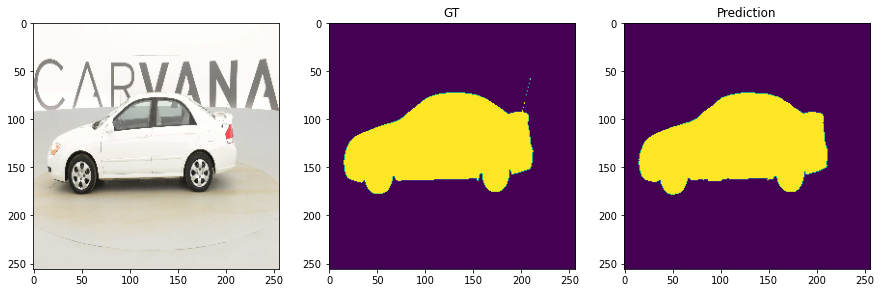

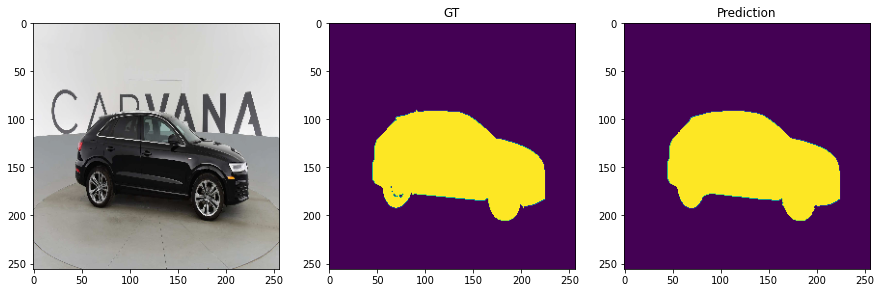

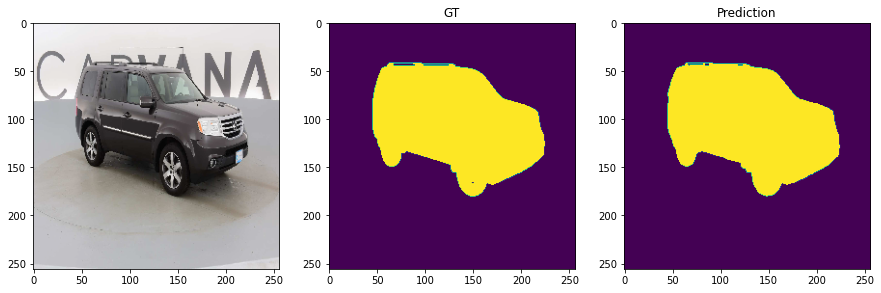

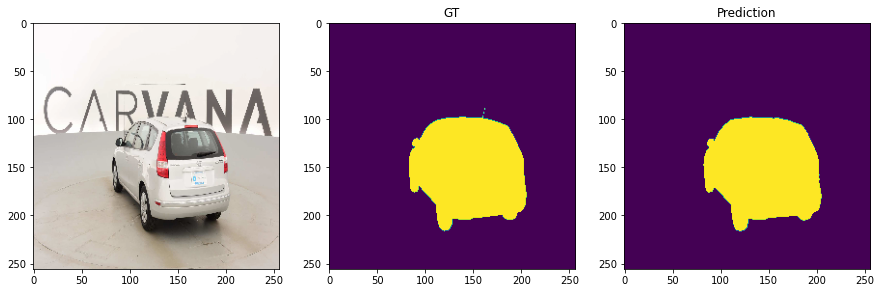

In [117]:
inference_val(model, valloader)

In [125]:
def inference_test(model, test_folder, NUM_PIC = 5):

    for i in range(NUM_PIC):
        test_path = os.listdir(test_folder)
        a = np.random.randint(len(test_path))
        test_img = os.path.join(test_folder, test_path[a])
        test_img = Image.open(test_img)

        model.eval()
        with torch.no_grad():
            test_img_np = np.array(test_img)
            test_img_np = val_transforms(image = test_img_np)['image']
            test_img_tensor = ToTensor()(test_img_np).unsqueeze(0).to(device)
            outs = model(test_img_tensor)

        mask_out = outs.squeeze(0).squeeze(0).cpu()
        mask_out = (mask_out>0.5).float()

        img = denormalize(test_img_tensor.cpu())
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.subplot(1,2,2)
        plt.imshow(mask_out)
        plt.show()

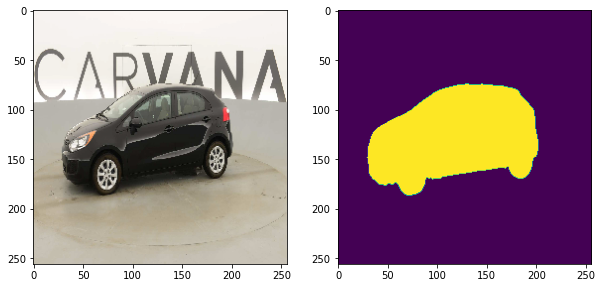

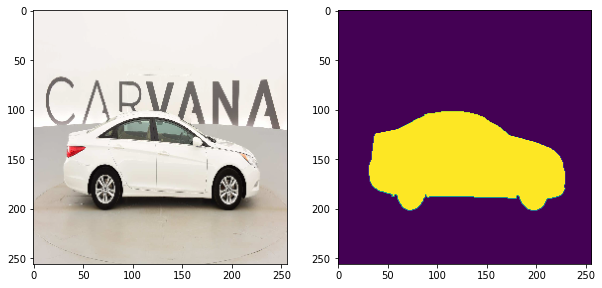

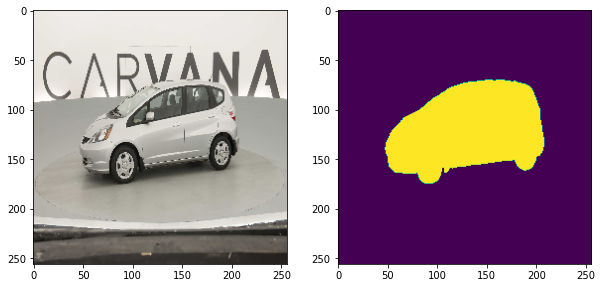

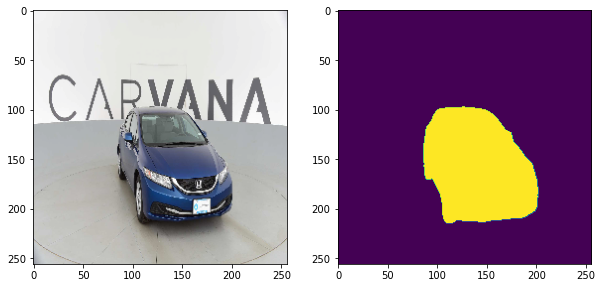

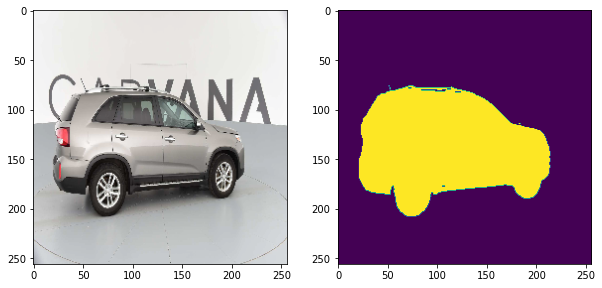

In [126]:
inference_test(model, '/content/carvana/images/test')